# 介绍

本文主要参考崔庆才的文章 [【2022 年】Python3 爬虫教程 - 经典动态渲染工具 Selenium 的使用](https://cuiqingcai.com/202261.html) 

对代码进行调整再加上验证码滑动操作 并在 [果核剥壳](https://www.ghxi.com/login) 网站上进行实践应用。

> 本文的滑动验证码 只是单纯的为了学习，并不涉及网站内容爬取的操作。
> 
> 应该不会收到律师函吧

# 代码

【图片】 (390, 680, 3)
【面积范围】 6833.249280000001 —— 10249.87392
【周长范围】 332.85600000000005 —— 406.82400000000007
【偏移范围】 163.2 —— 590.24
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'PIL.Image.Image'>
【识别成功】
【轮廓信息】 (486, 86, 87, 102) 【面积】 8874 【周长】 378
【当前偏移offset】 486
【识别成功】
【轮廓信息】 (486, 86, 87, 102) 【面积】 8874 【周长】 378
【当前偏移offset】 486
【期望偏移】 206.72899999999998


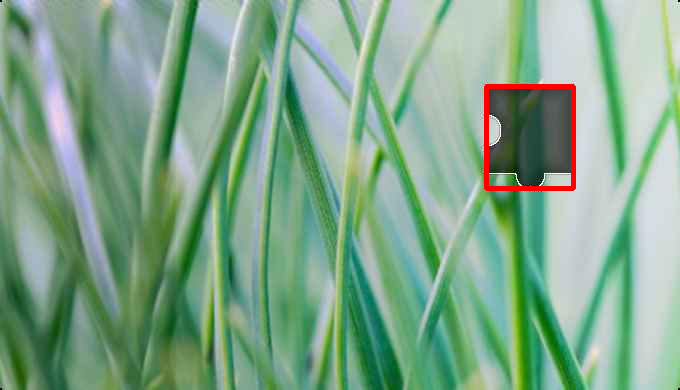

In [4]:
import cv2
import requests
import numpy as np
from PIL import Image
from io import BytesIO
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

GAUSSIAN_BLUR_KERNEL_SIZE = (5, 5)
GAUSSIAN_BLUR_SIGMA_X = 0
CANNY_THRESHOLD1 = 200
CANNY_THRESHOLD2 = 450

# 根据验证码图片链接获取图片
def by_src():
    image_src           = browser.find_element(By.CSS_SELECTOR, '#slideBg').get_attribute('src')
    image_by_src        = requests.get(image_src).content
    image_by_src        = Image.open(BytesIO(image_by_src))
    return image_by_src

# screenshot_as_png 方法
def by_screenshot():
    slideBgWrap         = browser.find_element(By.CSS_SELECTOR, '#slideBgWrap')
    image_by_screenshot = Image.open(BytesIO(slideBgWrap.screenshot_as_png))
    image_by_screenshot
    return image_by_screenshot

# 高斯滤波
def get_gaussian_blur_image(image):
    return cv2.GaussianBlur(image, GAUSSIAN_BLUR_KERNEL_SIZE, GAUSSIAN_BLUR_SIGMA_X)

# 边缘检测
def get_canny_image(image):
    return cv2.Canny(image, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

# 轮廓提取
def get_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# 宽度范围（10%误差）
def w_threshold(image_width):
    min_w = image_width * 0.132 * 0.9
    max_w = image_width * 0.132 * 1.1
    return min_w, max_w

# 高度范围（10%误差）
def h_threshold(image_height):
    min_h = image_height * 0.244 * 0.9
    max_h = image_height * 0.244 * 1.1
    return min_h, max_h

# 缺口面积范围（20%误差）
def get_contour_area_threshold(image_width, image_height):
    contour_area_min = (image_width * 0.132) * (image_height * 0.244) * 0.8
    contour_area_max = (image_width * 0.132) * (image_height * 0.244) * 1.2
    print('【面积范围】', contour_area_min, '——', contour_area_max)
    return contour_area_min, contour_area_max

# 缺口周长范围（20%误差）
def get_arc_length_threshold(image_width, image_height):
    arc_length_min = ((image_width * 0.132) + (image_height * 0.244)) * 2 * 0.9
    arc_length_max = ((image_width * 0.132) + (image_height * 0.244)) * 2 * 1.1
    print('【周长范围】', arc_length_min, '——', arc_length_max)
    return arc_length_min, arc_length_max

# 最小偏移与最大偏移
def get_offset_threshold(image_width):
    
    offset_min = 0.24  * image_width     # 缺口位置 最小偏移是验证码宽度的 0.24 倍
    offset_max = 0.868 * image_width     # 缺口位置 最大偏移是验证码宽度的 0.85 倍
    print('【偏移范围】', offset_min, '——', offset_max)
    return offset_min, offset_max

def test(img):
    image_raw                    = np.array(img)
    image_height, image_width, _ = image_raw.shape              # 验证码图片的尺寸（高度、宽度）
    print('【图片】', image_raw.shape)
    ### 目标轮廓的面积、周长、偏移
    contour_area_min, contour_area_max = get_contour_area_threshold(image_width, image_height)
    arc_length_min,   arc_length_max   = get_arc_length_threshold(image_width, image_height)
    min_w, max_w                       = w_threshold(image_width)
    min_h, max_h                       = h_threshold(image_height)
    offset_min,       offset_max       = get_offset_threshold(image_width)
    exception_offset = None
    # 图片处理
    image_gaussian_blur = get_gaussian_blur_image(image_raw)    # 高斯滤波
    image_canny         = get_canny_image(image_gaussian_blur)  # 边缘检测
    contours            = get_contours(image_canny)             # 轮廓提取

    print(type(image_raw))
    print(type(image_canny))
    print(type(Image.fromarray(image_canny.astype('uint8'))))
    
    ### 筛选出符合条件的轮廓 即为 验证码缺口轮廓
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)  # 各轮廓外框信息
        
        # 绘制外框
        color       = (255, 0, 0)   # 外框颜色
        start_point = (x, y)        # 外框起点
        end_point   = (x+w, y+h)    # 外框终点
        image_area  = w * h         # 外框面积
        image_arc   = (w + h) * 2   # 外框周长
             
        # 条件判断
        if contour_area_min < image_area < contour_area_max and \
            arc_length_min  < image_arc  < arc_length_max and \
            min_w           < w          < max_w and \
            min_h           < h          < max_h and \
            offset_min      < x          < offset_max:
            
            current_offset  = x
            # rec_image         = cv2.rectangle(image_canny, start_point, end_point, color, 4)
            rec_image         = cv2.rectangle(image_raw, start_point, end_point, color, 4)
            rec_image_finally = Image.fromarray(rec_image.astype('uint8'))
            print('【识别成功】')
            print('【轮廓信息】', (x, y, w, h), '【面积】', image_area, '【周长】', image_arc)
            print('【当前偏移offset】', current_offset)
            exception_offset = current_offset * 0.5015 - 37
   
    print('【期望偏移】', exception_offset)
    return rec_image_finally, exception_offset


### 主程序

browser = webdriver.Chrome()
browser.get('https://www.ghxi.com/login')
wait = WebDriverWait(browser, 10)
wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, '.captcha-button'))).click()
wait.until(EC.frame_to_be_available_and_switch_to_it((By.ID, 'tcaptcha_iframe')))       # 切换到验证码框架
# browser.switch_to.frame('tcaptcha_iframe')                                            # 切换到验证码框架
origin_position = wait.until(EC.presence_of_element_located((By.ID, 'tcaptcha_drag_thumb')))    # 滑块初始位置

actions = ActionChains(browser)
finally_image, offset = test(by_src())
actions.drag_and_drop_by_offset(origin_position, offset, 0)
actions.drag_and_drop_by_offset(origin_position, 0, 0)
actions.perform()       # 执行所存储的操作

finally_image           # 图片展示

# 展示

<img alt="图 1" src="../images/8dd0ce081d5c62bada3c5e3fdc80f70d78b588805abc0943cf7fc9ce080238da.png" width=45%/>  

<img alt="图 2" src="../images/4e57247203776b163a6afc2b72357e613e0727fc88cf538f1a791edada740056.png" width=45%/>  

<img alt="图 3" src="../images/cb644f86fd78e2a5dc6eca1bcca8d5bcec1df8685cf61918e1fbe1a81dc28a9f.png" width=45%/>  

<img alt="图 4" src="../images/78f032ff15c25d78eea069e6f48d28c9eef8eef4698bb40e08f366b908e8474a.png" width=45%/>  

# 说明

### 一、代码详解

### 二、核心问题

##### **1. 动作链（验证码滑块滑动）**

> 官方文档说明
> 
> [**`drag_and_drop_by_offset(source, xoffset, yoffset)`**](https://selenium-python-zh.readthedocs.io/en/latest/api.html#selenium.webdriver.common.action_chains.ActionChains.drag_and_drop_by_offset)

##### **2. `Selenium` 显示等待**

> 参考
-  [官方文档 `Explicit Waits`](https://selenium-python.readthedocs.io/waits.html#explicit-waits)
-  [崔庆才博客](https://cuiqingcai.com/202261.html)


> 本篇使用到的方法

|方法|说明|传入参数|备注|
|:-|:-:|:-:|:-:|
|**`EC.presence_of_element_located()`**|节点存在|**`定位元组`**|
|**`EC.element_to_be_clickable()`**|元素可点击|**`定位元组`**|
|**`EC.frame_to_be_available_and_switch_to_it()`**|框架可见并切换至此框架|**`定位元组`**|`browser.switch_to.frame()`|

```Python
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import excepted_conditions as EC

wait = WebDriverWait(driver, 10)
wait.unitl(EC.presence_of_element_located((By.ID, 'tcaptcha_drag_thumb')))
```

##### **3. 分析图片 和 处理图片 使用的并不是同一张图**